__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Вт 11 июн 2024 11:25:09 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_land.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

11379

,title,address,latitude,longitude,priceM,dt
11228,"участок 5 сот. (снт, днп)","севастополь,садовое товарищество заречный,10",44.683717,33.694728,1.50,2024-06-07
11037,"участок 6,5 сот. (снт, днп)","севастополь,кольцевая ул.",44.566214,33.482995,5.70,2024-06-07
3178,"участок, 4 сот., садоводство","севастополь,р-н гагаринский,херсонес садоводческое товарищество,50",44.559143,33.433049,3.50,2024-06-10


---

In [4]:
df_ = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

18854

,title,address,latitude,longitude,priceM,dt
16501,Участок 10 сот. (ИЖС),"Севастополь, Балаклавский район , садовое товарищество Скиф, 182",44.517696,33.504312,5.60,2023-01-10
8984,Участок 10 сот. (ИЖС),"Севастополь,садоводческий потребительский кооператив Водоканал-3",44.67725,33.686069,1.00,2022-10-08
13802,"Участок 4,5 сот. (ИЖС)","Севастополь,Гранатная ул., 1/3",44.609141,33.564877,3.00,2022-11-07


In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

18727

,title,address,latitude,longitude,priceM,dt,url
15225,Участок 5 сот. (ИЖС),"Севастополь,ул. 2-я Линия",44.679308,33.568802,1.20,2022-11-28,https://avito.ru/2611947258
14155,"Участок 5,7 сот. (ИЖС)","Севастополь,СТ Энергетик-2, ул. Летчика Кирсанова",44.574357,33.59347,2.50,2022-11-15,https://avito.ru/2175503160
3722,"Участок 3,5 сот. (ИЖС)","Севастополь,садовое товарищество Строитель СУ-432",44.578594,33.451743,4.51,2022-09-15,https://avito.ru/2422407942


In [6]:
# df_['dt'].drop_duplicates()

In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

30106

In [9]:
import numpy as np
df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))

---

In [10]:
# df['dt'].drop_duplicates().sort_values()

In [11]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

In [12]:
df['month'] = df['ts'].dt.to_period('M')

---

In [13]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30106 entries, 0 to 30105
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   url                 30106 non-null  object        
 1   place               30106 non-null  object        
 2   title               30106 non-null  object        
 3   subtitle            4581 non-null   object        
 4   price               30106 non-null  int64         
 5   address             30106 non-null  object        
 6   description         30106 non-null  object        
 7   ts                  30106 non-null  datetime64[ns]
 8   area                30106 non-null  float64       
 9   is_IJS              30106 non-null  bool          
 10  priceM              30106 non-null  float64       
 11  priceMU             30106 non-null  float64       
 12  area_size_category  30063 non-null  category      
 13  address_orig        11379 non-null  object    

In [15]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 


df.loc[ df['address'].str.lower().str.match('бахчисарай.*надежда.*'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('бахчисарай.*с.дачное.*'), ['latitude','longitude'] ] = None 
df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [16]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

30106

30082

In [17]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [18]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

,title,address,latitude,longitude,priceM,dt,url
24209,"Участок 9,4 сот. (ИЖС)","Севастополь,Тюбекская ул., 17к157",44.84,33.56,3.50,2022-11-04,https://avito.ru/1899272106
3258,участок 4 сотки ижс,"севастополь,р-н гагаринский,рыбак-6 садоводческое товарищество,улица евгения алисова,25",44.57,33.43,4.10,2024-06-10,https://sevastopol.cian.ru/sale/suburban/298455764/
5141,участок 5 сот. (ижс),"севастополь,мореходная ул.",44.61,33.56,3.00,2024-06-10,https://www.avito.ru/3530776537


---

In [19]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 8)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 11)

In [ ]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [20]:
# display( len(gdf_history) )
display( len(gdf) )

30082

In [21]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [22]:
# gdf['place'].unique()

# общая статистика

In [23]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [24]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [25]:
( 
    gdf.query('place=="sudak"')
    [['title','address','priceM','area_size_category','geometry']]
    #.explore('area_size_category', legend=True) 
    .explore()    
)

In [26]:
# gdf[
#     gdf['address'].str.match(r'бахчисарай.*с.дачное.*')
# ][['title','address','priceM','area_size_category','geometry']]

In [27]:
(
    gdf.query('place=="bahchisaray"')
    [['title','address','priceM','area_size_category','geometry']]
    #.sample(100)
    .explore() #'area_size_category', legend=True) 
)

In [28]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [29]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf.groupby(['place','area_size_category','month'],observed=True)['priceM'].describe(percentiles=percentiles)
# stat_history = gdf_history.groupby(['place','area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)

display( stat )
# display( stat_history )

count  mean   std  min   1%   5%  \
place       area_size_category month                                        
bahchisaray <1                 2024-06    6.00  0.90  0.11 0.80 0.80 0.80   
            1-2                2024-06   15.00  2.60  2.35 0.50 0.50 0.50   
            2-4                2024-06   18.00  3.15  1.19 1.80 1.80 1.80   
            4-8                2024-06  369.00  1.99  1.26 0.15 0.30 0.40   
            8-20               2024-06  451.00  2.21  2.29 0.23 0.30 0.47   
            20+                2024-06 1051.00  5.42 10.39 0.00 0.00 0.35   
sevastopol  <1                 2022-09   31.00  4.32  6.41 0.30 0.30 0.30   
                               2022-10    8.00  2.44  5.09 0.30 0.30 0.30   
                               2022-11   23.00  3.89  6.02 0.30 0.30 0.30   
                               2023-01    2.00  0.35  0.07 0.30 0.30 0.30   
                               2024-06  151.00  2.94  1.07 0.80 0.80 0.95   
            1-2                2022-09   37.00  1.39  0.49 0.65 0.65 0.65   
                               2022-10   14.00  1.76  1.16 0.65 0.65 0.65   
                               2022-11   22.00  1.89  1.16 0.65 0.65 0.65   
                               2023-01    6.00  2.94  3.51 0.65 0.68 0.79   
                               2024-06  179.00  3.82  2.99 0.55 0.55 1.00   
            2-4                2022-09 1204.00  3.51  2.25 0.00 0.68 1.35   
                               2022-10  304.00  3.36  1.89 0.00 0.61 1.40   
                               2022-11  729.00  2.96  1.57 0.00 0.69 1.25   
                               2023-01  112.00  3.01  1.64 0.68 0.77 1.30   
                               2024-06 2027.00  3.30  1.98 0.65 1.30 1.65   
            4-8                2022-09 4428.00  4.38  3.88 0.00 0.82 1.49   
                               2022-10 1119.00  4.26  3.55 0.00 0.93 1.45   
                               2022-11 2622.00  4.11  3.88 0.00 0.95 1.45   
                               2023-01  416.00  4.05  3.91 0.00 0.90 1.40   
                               2024-06 4330.00  4.13  3.43 0.35 0.88 1.36   
            8-20               2022-09 2790.00  6.29  6.35 0.00 0.80 1.60   
                               2022-10  701.00  6.03  6.06 0.00 1.00 1.50   
                               2022-11 1579.00  5.80  5.24 0.00 0.98 1.45   
                               2023-01  267.00  5.92  5.26 0.00 0.77 1.26   
                               2024-06 2505.00  5.75  8.07 0.00 0.80 1.46   
            20+                2022-09  308.00 31.56 31.68 0.00 0.80 2.10   
                               2022-10   62.00 25.69 24.79 0.00 0.00 0.84   
                               2022-11  177.00 30.13 27.39 1.00 1.50 1.55   
                               2023-01   23.00 41.50 48.51 1.55 1.87 3.15   
                               2024-06  937.00 11.85 25.16 0.00 0.80 1.40   
sudak       <1                 2024-06   27.00  1.32  1.20 0.50 0.50 0.50   
            1-2                2024-06   14.00  4.20  1.77 2.00 2.00 2.00   
            2-4                2024-06   49.00  5.37  4.55 0.94 1.26 1.60   
            4-8                2024-06  628.00  3.50  3.24 0.00 0.53 1.09   
            8-20               2024-06  207.00  5.84  5.70 0.88 0.89 1.10   
            20+                2024-06   91.00 10.60  8.20 0.80 0.80 1.50   

                                        10%   25%   50%   75%   90%    max  
place       area_size_category month                                        
bahchisaray <1                 2024-06 0.80  0.80  0.90  1.00  1.00   1.00  
            1-2                2024-06 0.50  1.50  2.00  2.00  7.00   7.00  
            2-4                2024-06 1.80  2.50  2.80  3.68  4.33   5.80  
            4-8                2024-06 0.50  1.00  1.95  2.50  3.80   6.90  
            8-20               2024-06 0.60  0.90  1.60  2.65  3.50  16.20  
            20+                2024-06 0.56  1.00  2.15  4.75 12.50 100.00  
sevastopol  <1                 2022-

In [ ]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9]
# stat = gdf.groupby(['place','area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [30]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
#sizes = stat.reset_index()['area_size_category'].unique()
sizes = [ '2-4', '4-8', '8-20']
display( sizes )

['2-4', '4-8', '8-20']

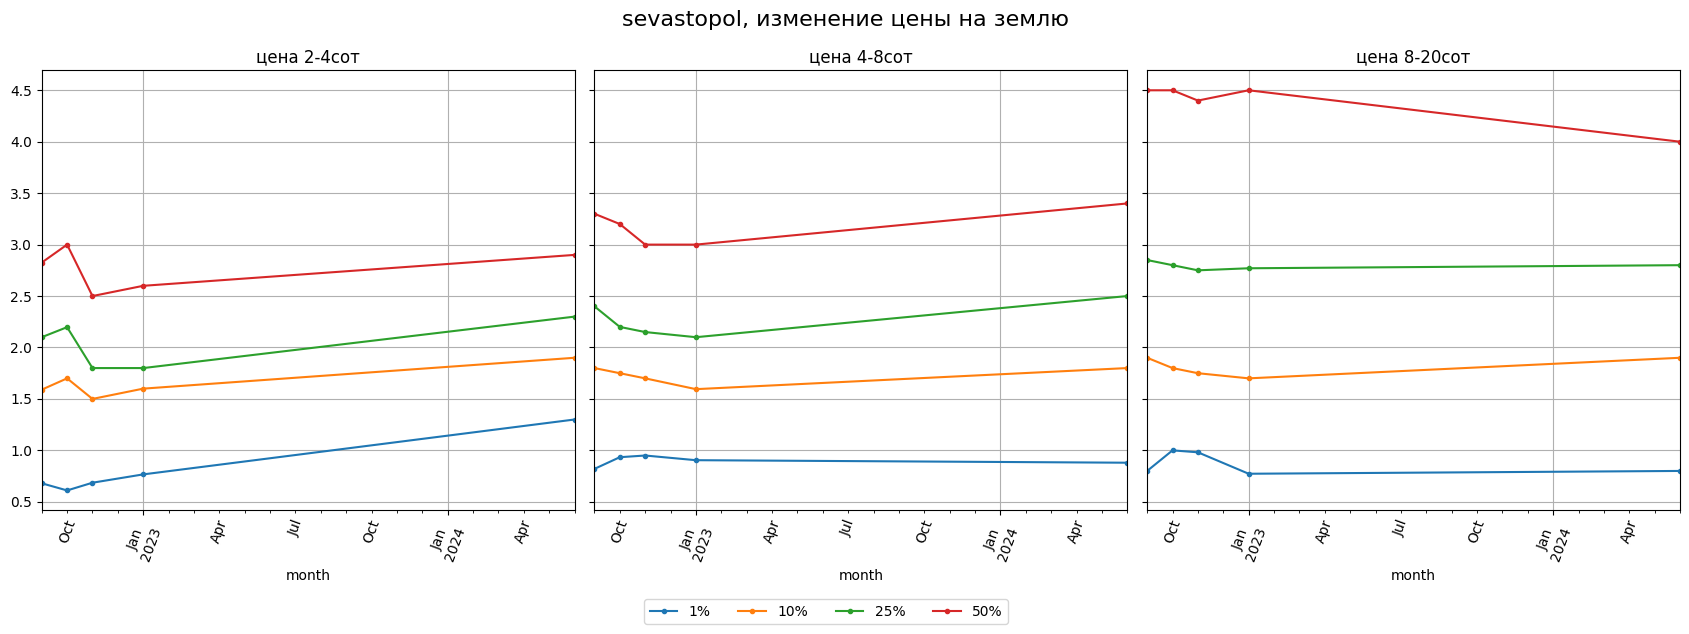

In [32]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/panda

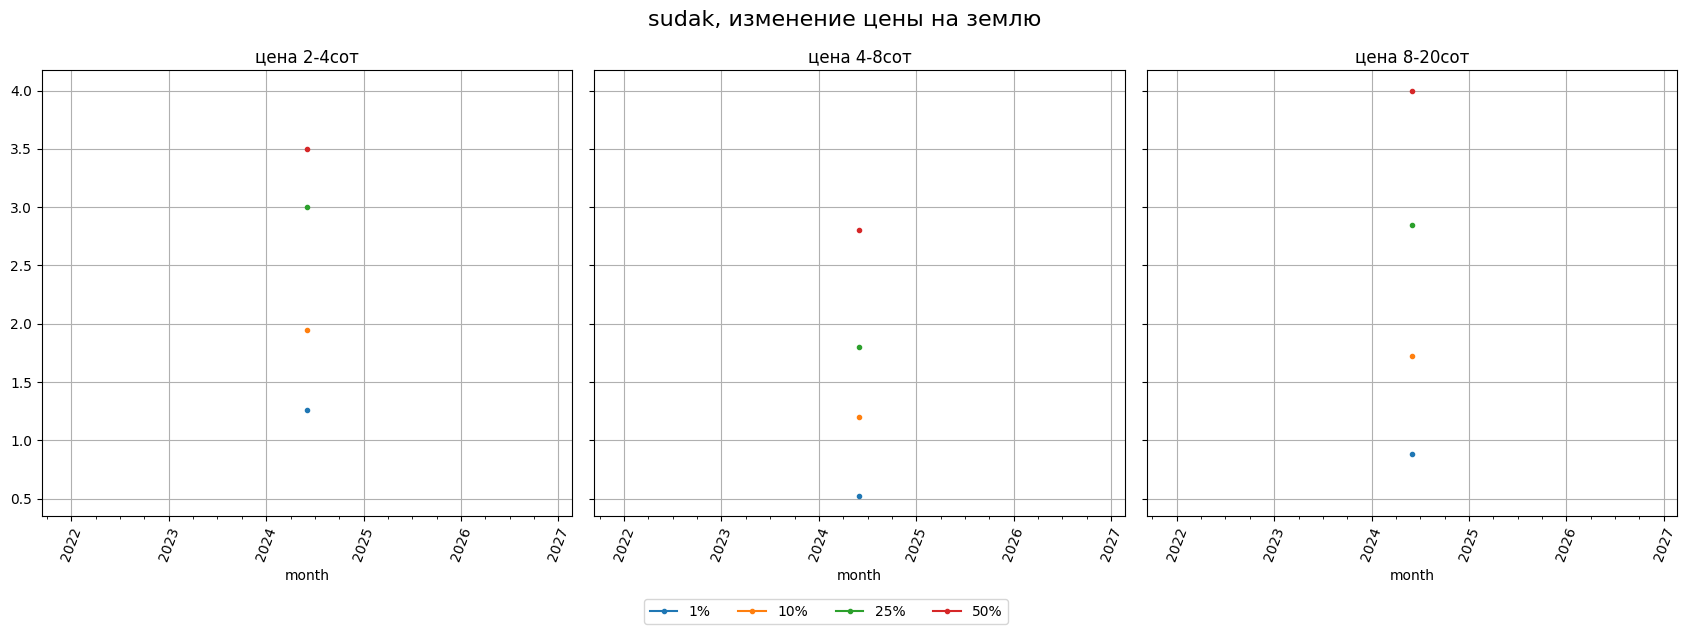

In [33]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/panda

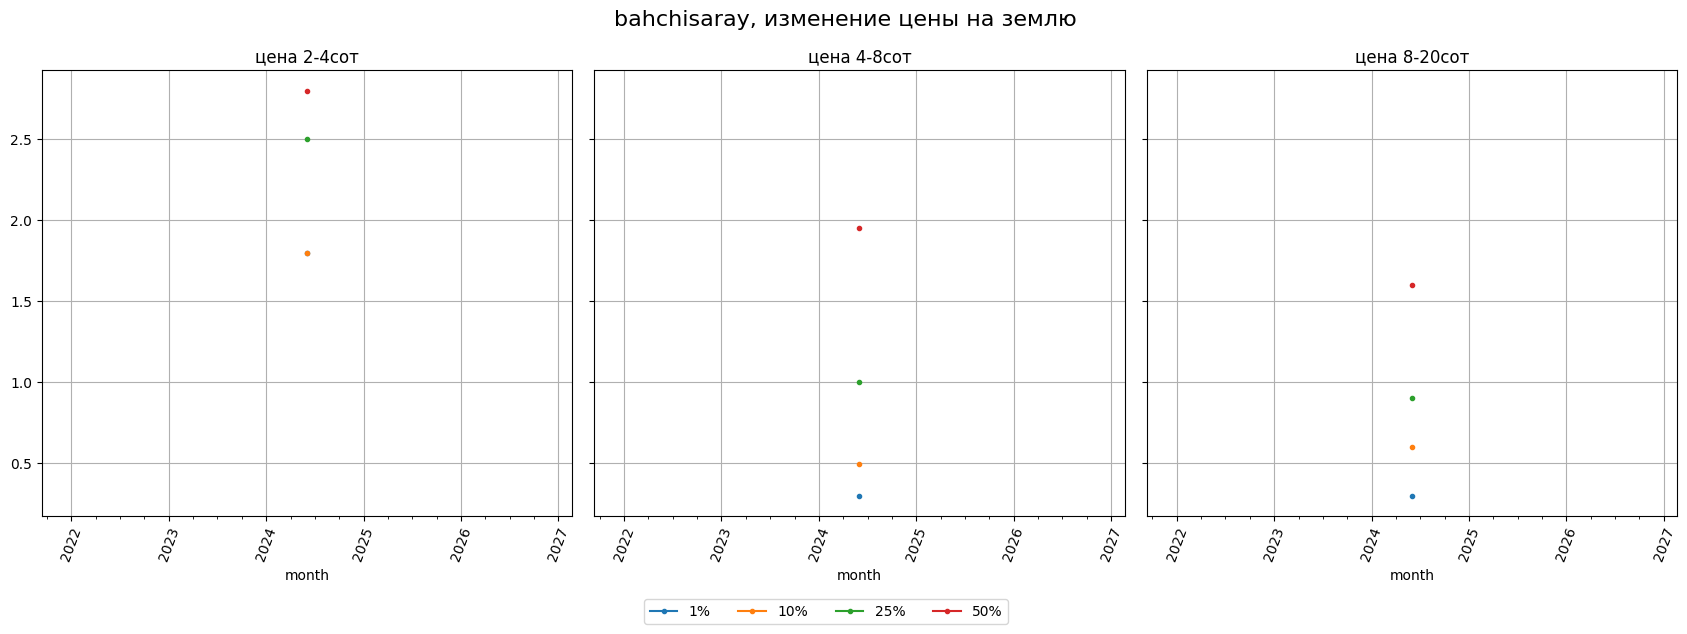

In [34]:
place = 'bahchisaray'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

In [ ]:
# place = 'sevastopol'

# fig, ax = plt.subplots(2,len(sizes),figsize=(17,12), sharey=True )

# for i,s in enumerate(sizes): 
#     stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[1][i],legend=False, rot=70, style='.-' )   
#     stat_history.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[0][i],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

In [ ]:
# place = 'bahchisaray'

# fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=True )
# for i,s in enumerate(sizes): 
#     stat.loc[(place,s),cols].plot(title=f'цена за {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

In [ ]:
# place = 'sudak'

# fig, ax = plt.subplots(1,len(sizes),figsize=(17,5), sharey=True )
# for i,s in enumerate(sizes): 
#     stat.loc[(place,s),cols].plot(title=f'цена за {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

# fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
# fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
# fig.tight_layout()

# актуальная цена

In [35]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

30082

3904

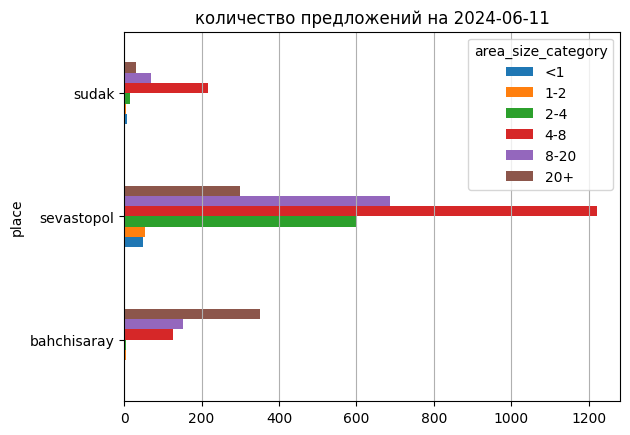

In [36]:
(
gdf_last
.groupby(['area_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='area_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [37]:
(
    gdf_last
    .groupby(['place','area_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean   std  min   1%   5%  10%  25%  \
place       area_size_category                                                
bahchisaray <1                    2.00  0.90  0.14 0.80 0.80 0.81 0.82 0.85   
            1-2                   5.00  2.60  2.53 0.50 0.54 0.70 0.90 1.50   
            2-4                   6.00  3.37  1.39 1.80 1.83 1.98 2.15 2.58   
            4-8                 125.00  2.01  1.28 0.15 0.30 0.40 0.49 1.10   
            8-20                152.00  2.22  2.40 0.23 0.33 0.48 0.60 0.90   
            20+                 351.00  5.44 10.48 0.00 0.00 0.35 0.55 1.00   
sevastopol  <1                   48.00  3.04  1.02 0.80 0.80 1.12 1.27 2.50   
            1-2                  55.00  3.66  2.94 0.55 0.66 0.99 1.38 2.20   
            2-4                 599.00  3.33  1.97 0.65 1.30 1.70 1.95 2.30   
            4-8                1220.00  3.97  2.93 0.35 0.85 1.35 1.70 2.50   
            8-20                687.00  5.48  7.87 0.59 0.75 1.40 1.80 2.70   
            20+                 298.00  9.35 20.77 0.00 0.79 1.39 1.80 2.60   
sudak       <1                    8.00  1.24  1.03 0.50 0.50 0.52 0.54 0.62   
            1-2                   5.00  4.40  1.90 2.00 2.04 2.20 2.40 3.00   
            2-4                  16.00  5.47  4.65 1.60 1.65 1.86 2.27 3.00   
            4-8                 217.00  3.52  3.24 0.00 0.63 1.10 1.20 1.80   
            8-20                 70.00  5.68  4.77 0.88 0.96 1.15 1.78 2.99   
            20+                  30.00 10.62  8.29 0.80 1.00 2.04 2.83 4.88   

                                50%   75%   90%    max  
place       area_size_category                          
bahchisaray <1                 0.90  0.95  0.98   1.00  
            1-2                2.00  2.00  5.00   7.00  
            2-4                3.20  3.68  4.75   5.80  
            4-8                1.95  2.50  3.76   6.90  
            8-20               1.60  2.60  3.50  16.20  
            20+                2.10  4.97 12.00 100.00  
sevastopol  <1                 3.15  3.73  4.06   4.90  
            1-2                3.20  4.20  5.66  18.50  
            2-4                3.00  3.80  4.50  22.40  
            4-8                3.30  4.50  6.40  36.00  
            8-20               4.00  5.50  8.94 120.00  
            20+                3.50  4.78 16.00 157.50  
sudak       <1                 0.80  1.50  2.13   3.60  
            1-2                4.80  5.50  6.22   6.70  
            2-4                4.00  5.72  9.35  20.00  
            4-8                2.81  3.95  6.00  30.00  
            8-20               4.10  6.50 11.50  22.00  
            20+                7.40 15.45 22.50  30.00

# цены на карте

In [38]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [39]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [40]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [41]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [42]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [43]:
# gdf_last.query('place=="sevastopol"')[['priceM']].describe([.9,.95,.99]).T

In [44]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    # .sjoin( gdf_last.query('(place=="sevastopol")&(priceM<10.0)'), how='inner',)
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

## Судак

In [45]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [46]:
# gdf_last.query('place=="sudak"')[['priceM']].describe([.9,.95,.99]).T

In [47]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
   [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

# районы Севастополя

In [48]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [49]:
display(frames)

,area_name,geometry
0,"Севастополь, район Острякова","POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))"
1,"Севастополь, парк 60-летия СССР","POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))"
2,"Севастополь, Хрусталёва/Хрюкина","POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))"
3,"Севастополь, Геловани/Коломийца","POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))"
4,"Севастополь, Музыки/Бирюзова","POLYGON ((33.52027 44.57528, 33.51724 44.58719, 33.52038 44.58724, 33.52554 44.58091, 33.52561 44.57790, 33.52027 44.57528))"
5,"Севастополь, кр.горка (старый)","POLYGON ((33.52932 44.59395, 33.53014 44.59336, 33.53265 44.59419, 33.53374 44.59431, 33.53651 44.59412, 33.54230 44.59142, 33.54644 44.58708, 33.54577 44.58522, 33.54406 44.58269, 33.54076 44.58366, 33.53883 44.58383, 33.53664 44.58511, 33.53142 44.58626, 33.53025 44.58780, 33.53048 44.58861, 33.53046 44.58847, 33.53167 44.59039, 33.53092 44.59122, 33.52951 44.59116, 33.52879 44.59244, 33.52895 44.59355, 33.52932 44.59395))"
6,"Севастополь, кр.горка (новый)","POLYGON ((33.54571 44.58517, 33.54652 44.58705, 33.54904 44.58565, 33.55000 44.58541, 33.55054 44.58522, 33.55089 44.58423, 33.55253 44.58415, 33.55326 44.58470, 33.55368 44.58431, 33.55371 44.58320, 33.55522 44.58246, 33.55548 44.58219, 33.55564 44.58115, 33.55564 44.58115, 33.55644 44.58055, 33.55694 44.57984, 33.55718 44.57912, 33.55936 44.57821, 33.56045 44.57706, 33.56229 44.57552, 33.56283 44.57476, 33.55749 44.57202, 33.55674 44.57395, 33.55618 44.57483, 33.55600 44.57601, 33.55286 44.57827, 33.55293 44.57910, 33.55259 44.58172, 33.55269 44.58302, 33.55003 44.58331, 33.54838 44.58436, 33.54571 44.58509, 33.54571 44.58517))"
7,"Севастополь, Малахов курган","POLYGON ((33.54313 44.60612, 33.55331 44.61155, 33.55676 44.60803, 33.55772 44.60255, 33.55385 44.60019, 33.54414 44.60247, 33.54313 44.60612))"
8,"Севастополь, Благополучный","POLYGON ((33.56498 44.57145, 33.56348 44.57083, 33.56274 44.57070, 33.56182 44.57017, 33.56179 44.56990, 33.55967 44.56941, 33.55751 44.57190, 33.55756 44.57213, 33.56302 44.57463, 33.56498 44.57145))"


In [50]:
frames.explore('area_name', legend=True)

In [51]:
area_name=[
    #'Севастополь, парк 60-летия СССР',
    #'Севастополь, Хрусталёва/Хрюкина',
    #'Севастополь, район Острякова',
    #'Севастополь, Малахов курган',
    'Севастополь, кр.горка (старый)',
    'Севастополь, кр.горка (новый)',
    'Севастополь, Благополучный',
    ]

In [52]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_ = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_[['title','priceM','address','geometry']].explore( legend=False)

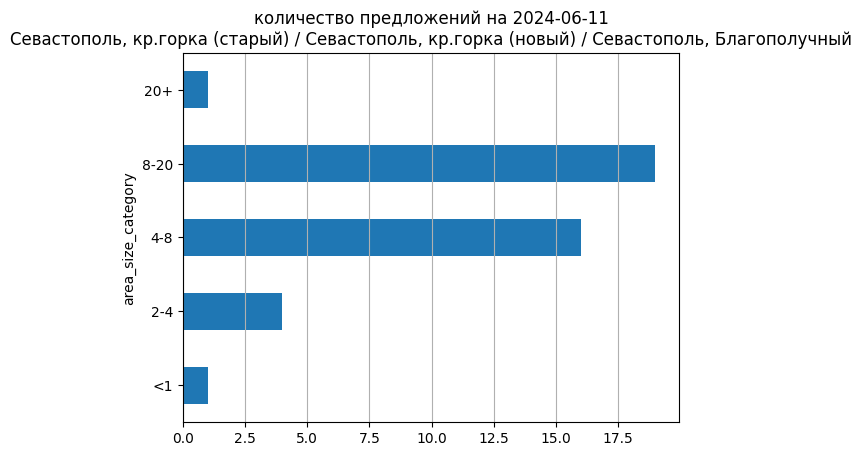

In [53]:
(
        gdf_
        .groupby(['area_size_category'], observed=True)['url'].count()
        .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
        .grid(axis='x')    
    )

----

In [54]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 
# gdf_local_history = gdf_history.sjoin( frame_, how='inner', predicate='within') 

In [55]:
# stat = gdf_local.groupby(['house_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)
# display( stat )

In [56]:
# sizes = [ '50-70', '70-150', '150-300', ]

In [59]:
percentiles=[.01,.05,.1,.25,.5,.75,.9]
stat = gdf_local.groupby(['area_size_category','month'],observed=True)['priceM'].describe(percentiles=percentiles)
# stat_history = gdf_local_history.groupby(['area_size_category','dt'],observed=True)['priceM'].describe(percentiles=percentiles)

display( stat )
# display( stat_history )

count  mean  std  min   1%   5%  10%  25%  50%  \
area_size_category month                                                     
<1                 2024-06   3.00  3.70 0.00 3.70 3.70 3.70 3.70 3.70 3.70   
2-4                2022-09  59.00  2.84 0.64 1.90 1.90 2.45 2.45 2.60 2.65   
                   2022-10  16.00  2.62 0.53 1.90 1.90 1.90 2.05 2.25 2.62   
                   2022-11  45.00  2.59 0.47 2.00 2.00 2.00 2.14 2.35 2.40   
                   2023-01   6.00  2.50 0.65 1.90 1.90 1.92 1.95 2.09 2.35   
                   2024-06  15.00  4.16 1.96 1.80 1.80 1.80 1.80 2.80 2.80   
4-8                2022-09 216.00  3.64 1.69 1.45 1.45 1.80 1.80 2.20 3.20   
                   2022-10  54.00  3.71 1.55 1.80 1.80 1.90 2.00 2.30 3.25   
                   2022-11 119.00  3.65 1.60 1.60 1.62 1.80 1.95 2.30 3.20   
                   2023-01  14.00  3.76 1.38 1.50 1.56 1.82 2.09 2.52 4.08   
                   2024-06  66.00  5.21 2.71 2.45 2.45 2.45 2.55 3.20 4.20   
8-20               2022-09 114.00  6.43 3.91 2.15 2.15 2.56 3.00 4.06 4.93   
                   2022-10  20.00  5.22 2.68 2.90 2.90 2.90 2.90 3.90 4.80   
                   2022-11  55.00  5.21 3.36 2.60 2.76 2.90 2.90 3.60 4.20   
                   2023-01   9.00  5.89 4.04 2.50 2.52 2.62 2.74 4.10 4.50   
                   2024-06  74.00  6.14 3.95 2.10 2.10 2.10 3.50 4.25 4.93   
20+                2024-06   3.00  4.50 0.00 4.50 4.50 4.50 4.50 4.50 4.50   

                            75%   90%   max  
area_size_category month                     
<1                 2024-06 3.70  3.70  3.70  
2-4                2022-09 2.80  3.70  6.50  
                   2022-10 2.78  3.35  3.70  
                   2022-11 2.70  3.42  3.70  
                   2023-01 2.61  3.20  3.70  
                   2024-06 6.00  6.30  6.50  
4-8                2022-09 4.72  6.00  8.50  
                   2022-10 4.80  6.21  6.70  
                   2022-11 4.65  6.30  8.50  
                   2023-01 4.88  5.41  5.60  
                   2024-06 6.65  9.50 12.00  
8-20               2022-09 6.60 12.00 17.00  
                   2022-10 5.80  6.74 15.00  
                   2022-11 4.85  7.84 20.00  
                   2023-01 4.70 12.34 13.70  
                   2024-06 5.50 12.85 16.00  
20+                2024-06 4.50  4.50  4.50

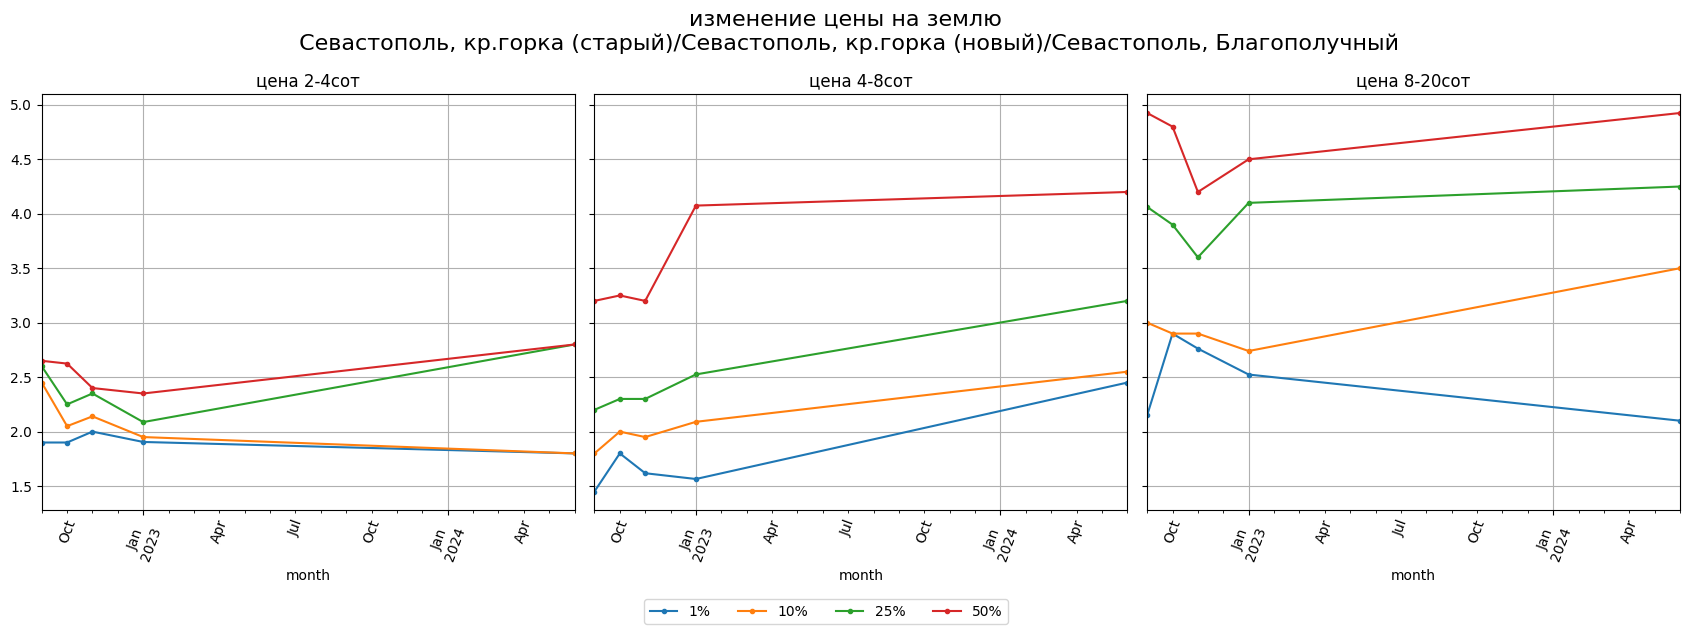

In [60]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на землю\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()